This example is an explained version of https://github.com/psycharo/cpm, which is based on https://github.com/shihenw/convolutional-pose-machines-release

In [3]:
from __future__ import print_function
from __future__ import division

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pickle

import skimage.io
import skimage.transform
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
import cv2

import os

In [2]:
import tensorflow as tf

#Use specific GPU to train your model, does not work well with .ipynb (should work fine with .py)
#os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [1]:
import cpm

In [4]:
def detect_objects_heatmap(heatmap):
    data = 256 * heatmap
    
    # scipy's maximum_filter is used to create a filtered array of the same size as the original picture
    # size equals 3, so every 3x3 pixels are set to their maximum value
    data_max = filters.maximum_filter(data, 3, mode='reflect')
    
    # we compare the original data to the output of the maximum filter to find the indexes of the maxima
    maxima = (data == data_max)
    
    # similarly, we create data_min, where every 3x3 are set to their minimum value
    data_min = filters.minimum_filter(data, 3, mode='reflect')
    
    # we find the pixels where the difference between data_max and data_min is greater than 0.3
    diff = ((data_max - data_min) > 0.3)
    
    # update maxima by setting the pixels where the difference is not greater than 0.3 to 0
    maxima[diff == 0] = 0
    
    # using scipy's labels, the zeros will be considered "background"
    # all the other datapoints are "features" and we label and number them
    labeled, num_objects = ndimage.label(maxima)
    
    # we use find_object to find the indexes for the features.
    # each slice has two tuples, which hold the minimal parallelepiped that contains that object/feature.
    # slices = [((y1,y2), (x1,x2)), ((y1,y2), (x1,x2))]
    # y2 and x2 for each object is a ceiling (up to, not included)
    slices = ndimage.find_objects(labeled)
    
    # for each object/feature, we create a list of length two which is the index of the object centroid.
    objects = np.zeros((num_objects, 2), dtype=np.int32)
    for oid,(dy,dx) in enumerate(slices):
        # objects = [[0, [y_centroid, x_centroid]], [1, [y_centroid, x_centroid]]]
        objects[oid,:] = [(dy.start + dy.stop - 1)/2, (dx.start + dx.stop - 1)/2]
    return objects, slices

The Gaussian kernel for two dimensions is defined as:

$G(x,y,\sigma) = \frac{1}{2\pi\sigma^2}e^{-\frac{x^2+y^2}{2\sigma^2}}$

The sigma ($\sigma$) is considered the width of the Gaussian kernel. $\frac{1}{2\pi\sigma^2}$ is the normalization factor and will keep the area under the distribution curve uniform, or: if we use the Gaussian kernel on a greyscale image, this would keep the average grey level the same. The kernel can be interpreted as a similarity measure, or used to blur an image to reduce noise and to enhance the structure of an image.

In [5]:
def gaussian_kernel(h, w, sigma_h, sigma_w):
    yx = np.mgrid[-h//2:h//2,-w//2:w//2]**2
    return np.exp(-yx[0,:,:] / sigma_h**2 - yx[1,:,:] / sigma_w**2)

In [6]:
def prepare_input_posenet(image, objects, size_person, size, sigma=25, max_num_objects=16, border=400):
    # the result will be for every object a "picture" with 4 layers
    result = np.zeros((max_num_objects, size[0], size[1], 4))
    
    padded_image = np.zeros((1,size_person[0]+border,size_person[1]+border,4))
    # for the image we only take the RGB values (first three in the list), the last layer is still zeros
    padded_image[0,border//2:-border//2,border//2:-border//2,:3] = image
    
    #raises error if there are more objects than max_num_objects
    assert len(objects) < max_num_objects
    
    for object_id, (y_coord, x_coord) in enumerate(objects):
        dh, dw = size[0]//2, size[1]//2
        y0, x0, y1, x1 = np.array([y_coord-dh, x_coord-dw, y_coord+dh, x_coord+dw]) + border//2
        result[object_id,:,:,:4] = padded_image[:,y0:y1,x0:x1,:]
        result[object_id,:,:,3] = gaussian_kernel(size[0], size[1], sigma, sigma)
        
    # split along axis=3, [3] indicates [:3] and [3:]
    return np.split(result, [3], 3)

In [7]:
def detect_parts_heatmaps(heatmaps, centers, size, num_parts=14):
    parts = np.zeros((len(centers), num_parts, 2), dtype=np.int32)
    for oid, (yc, xc) in enumerate(centers):
        part_hmap = skimage.transform.resize(np.clip(heatmaps[oid], -1, 1), size, 
                                         mode='reflect') 
        for pid in range(num_parts):
            y, x = np.unravel_index(np.argmax(part_hmap[:,:,pid]), size)
            parts[oid,pid] = y+yc-size[0]//2,x+xc-size[1]//2
    return parts

LIMBS = np.array([1, 2, 3, 4, 4, 5, 6, 7, 7, 8, 9, 10, 10, 11, 12, 13, 13, 14]).reshape((-1,2))-1
COLORS = [[0, 0, 255], [0, 170, 255], [0, 255, 170], [0, 255, 0], [170, 255, 0],
          [255, 170, 0], [255, 0, 0], [255, 0, 170], [170, 0, 255]]

def draw_limbs(image, parts):
    #for oid in range(parts.shape[0]):
        for lid, (p0, p1) in enumerate(LIMBS):
            y0, x0 = parts[0][p0]
            y1, x1 = parts[0][p1]
            cv2.line(image, (x0,y0), (x1,y1), COLORS[lid], 2)
            
# thickness set to 5 for visibility
def draw_points(image, parts):
    for i in range(14):
        y1, x1 = parts[0][i]
        cv2.line(image, (x1,y1), (x1,y1), [255,255,255], 5)

For this example, we are using pretrained models created by Timur Bagautdinov.

1. Download all files from: https://drive.google.com/open?id=0Bw6m_66JSYLld0NESGQ4QUNEdFk
2. Save them in the same folder as this notebook
3. Set the path to the pretrained models:

In [8]:
person_net_path = os.path.join(os.getcwd(), 'person_net.ckpt') 
pose_net_path = os.path.join(os.getcwd(), 'pose_net.ckpt')

# if you do not want to save them in the same folder, alternatively
# model_path = '<enter-path-to-folder-that-is-not-current-folder>'
# person_net_path = os.path.join(model_path, 'person_net.ckpt') 
# pose_net_path = os.path.join(model_path, 'pose_net.ckpt')

In [9]:
tf.reset_default_graph()

with tf.variable_scope('CPM'):
    # input dims for the person network
    PH, PW = 376, 656
    image_in = tf.placeholder(tf.float32, [1,PH,PW,3])
    heatmap_person = cpm.inference_person(image_in)
    heatmap_person_large = tf.image.resize_images(heatmap_person, [PH, PW])
    
    # input dims for the pose network
    N, H, W = 16, 376, 376
    pose_image_in = tf.placeholder(tf.float32, [N,H,W,3])
    pose_centermap_in = tf.placeholder(tf.float32, [N,H,W,1])
    heatmap_pose = cpm.inference_pose(pose_image_in, pose_centermap_in)

In [10]:
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
tf_config.allow_soft_placement = True

In [11]:
fname = 'nadal.png'

image = skimage.io.imread(fname)

# Resizing the image. 'nadal.png' will have shape (376, 656, 3), because the picture is 376x656 pixels and there is
# a layer for each color (R,G,B)
image = skimage.transform.resize(image, [PH, PW], mode='constant', 
                                 preserve_range=True).astype(np.uint8)

In [12]:
restorer = tf.train.Saver(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 
                                            'CPM/PersonNet'))

with tf.Session(config=tf_config) as sess:
    restorer.restore(sess, person_net_path)
    b_image = image[np.newaxis] / 255.0 - 0.5
    hmap_person = sess.run(heatmap_person_large, { image_in : b_image })
    
print('done detecting')

INFO:tensorflow:Restoring parameters from /Users/Justin/Desktop/Emma/wyzant/cpm/person_net.ckpt
done detecting


In [13]:
# TODO: make this in tf as well?  
hmap_person = np.squeeze(hmap_person)  
centers, slices = detect_objects_heatmap(hmap_person)  
b_pose_image, b_pose_cmap = prepare_input_posenet(b_image[0], centers, [PH, PW], [H, W])  

In [14]:
restorer = tf.train.Saver(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 
                                            'CPM/PoseNet'))

with tf.Session(config=tf_config) as sess:
    restorer.restore(sess, pose_net_path)
    feed_dict = {
        pose_image_in : b_pose_image,
        pose_centermap_in : b_pose_cmap
    }
    _hmap_pose = sess.run(heatmap_pose, feed_dict)

INFO:tensorflow:Restoring parameters from /Users/Justin/Desktop/Emma/wyzant/cpm/pose_net.ckpt


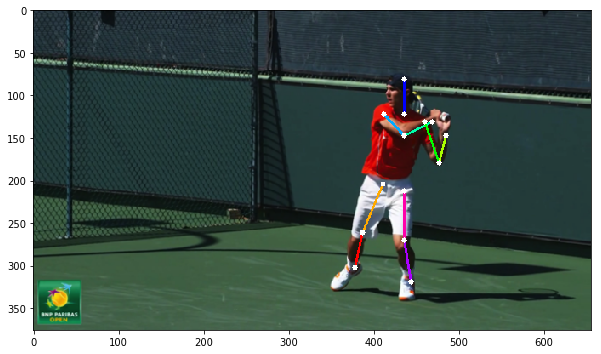

In [15]:
parts = detect_parts_heatmaps(_hmap_pose, centers, [H, W])
draw_limbs(image, parts)
draw_points(image, parts)
plt.figure(figsize=(10,10))
plt.imshow(image)